In [12]:
import numpy as np
import json
import matplotlib.pyplot as plt

In [367]:
with open('wp-15.json') as f:
    group = json.load(f)
    projector = group['projector']

with open('wp-15-01.json') as f:
    group = json.load(f)
e = np.array(group['members'][0]).reshape(3,3)
#e = np.array([0, 0, 0, 0., 0, 0, 0, 0, 1]).reshape(3,3)
basis = np.array(projector).reshape(4,4) @ np.array([50,0,0,50])
basis = basis.reshape(2,2)
#basis = np.eye(2)
ib = np.linalg.inv(basis)
print(e)
print(ib)
print(basis)
print(ib @ basis)

[[0.         0.         0.66666667]
 [0.         0.         0.33333333]
 [0.         0.         1.        ]]
[[0.01       0.0057735 ]
 [0.         0.01154701]]
[[100.      -50.     ]
 [  0.       86.60254]]
[[ 1.00000000e+00 -3.54762537e-17]
 [ 0.00000000e+00  1.00000000e+00]]


In [368]:
def scale(x, ib=ib):
    s = x @ ib.T
    return np.fmod(s, 1.0)
def unscale(x, basis=basis):
    return  x @ basis.T
x = np.array([0.5, 0.5])
print(x)
print(unscale(x))
print(scale(unscale(x)))

[0.5 0.5]
[25.      43.30127]
[0.5 0.5]


In [369]:
def pa(x, e=e):
    return (e @ (np.concatenate((x, [1])).T))[:2]
pa(x)

array([0.66666667, 0.33333333])

In [370]:
# compute A matrix
N = 2
A = np.zeros((N, N))
ibt = ib
grad = e[:-1,:-1] @ ibt - ibt
print('grad', grad)
print(A)
A = grad @ grad
print(A)
Ainv = np.linalg.pinv(A)
print(Ainv)
print(Ainv @ A)
Ainv = Ainv @ grad
print(Ainv)


grad [[-0.01       -0.0057735 ]
 [ 0.         -0.01154701]]
[[0. 0.]
 [0. 0.]]
[[0.0001     0.0001244 ]
 [0.         0.00013333]]
[[ 1.00000000e+04 -9.33012700e+03]
 [-4.69659974e-13  7.49999993e+03]]
[[ 1.00000000e+00  2.66448033e-16]
 [-4.69659974e-17  1.00000000e+00]]
[[-1.00000000e+02  5.00000000e+01]
 [ 4.69659974e-15 -8.66025400e+01]]


In [371]:
def step(x, v, f, dt, gamma=0.05, T = 0.2):
    # b
    #v += f(x) * dt / 2
    # a 
    x += v * dt / 2
    # constraint 1
    s = scale(x)
    delta = pa(s) - s
    print('delta:', delta, 's', s, 'x', x)
    l = Ainv @ delta.T
    print('lambda', l)    
    v -= l / dt * 2
    x -= l
    s = scale(x)
    delta = pa(s) - s
    print('after delta:', delta, 's', s, 'x', x)
    # o
    c1 = np.exp(-gamma * dt)
    c2 = np.sqrt(1 - c1**2)
    v *= c1
    v += c2 * np.random.normal() * np.sqrt(T)
    # a 
    x += dt * v / 2    
    # constraint 2
    s = scale(x)
    delta = pa(s) - s
    print('delta:', delta, 's', s, 'x', x)
    l = Ainv @ delta.T
    print('A lambda', A @ l)    
    v -= l / dt * 2
    x -= l
    s = scale(x)
    delta = pa(s) - s
    print('after delta:', delta, 's', s, 'x', x)
    # b
    v += f(x) * dt / 2
    return x,v
x = np.array([0.376419008701368, 0.008526634164955138], dtype=float)
x = unscale(x)
f = lambda x: -2 * np.sqrt(np.sum(x**2)) * x
v = np.array([0.5, 1], dtype=float)
N = 5
traj = np.empty((N, 2), dtype=float)
vtraj = np.empty((N, 2), dtype=float)
for i in range(N):
    traj[i,:] = x
    vtraj[i,:] = v
    x,v = step(x, v, f, 0.05)    
    print(x)

delta: [0.28997832 0.32451802] s [0.37668835 0.00881531] x [37.22806916  0.76342818]
lambda [-12.77193134 -28.10408487]
after delta: [0.00000000e+00 1.66533454e-16] s [0.66666667 0.33333333] x [50.0000005  28.86751304]
delta: [-0.28953151 -0.32400196] s [0.95619818 0.65733529] x [62.75305355 56.9269059 ]
A lambda [0.00476594 0.00374125]
after delta: [ 1.11022302e-16 -1.66533454e-16] s [0.66666667 0.33333333] x [50.0000005  28.86751304]
[50.0000005  28.86751304]
delta: [0.04811252 0.02405626] s [0.61855415 0.30927707] x [46.39156127 26.78417973]
lambda [-3.60843923 -2.08333331]
after delta: [0. 0.] s [0.66666667 0.33333333] x [50.0000005  28.86751304]
delta: [-4.84905932e-06 -3.54975780e-06] s [0.66667152 0.33333688] x [50.00030792 28.86782046]
A lambda [6.89851295e-08 4.09890726e-08]
after delta: [0. 0.] s [0.66666667 0.33333333] x [50.0000005  28.86751304]
[50.0000005  28.86751304]
delta: [0.04811252 0.02405626] s [0.61855415 0.30927707] x [46.39156127 26.78417973]
lambda [-3.60843923

(-2.500000000000015, 52.5, -0.9150634999999998, 19.216333499999994)

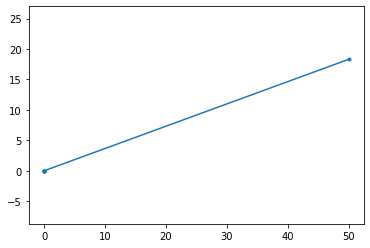

In [349]:
plt.plot(traj[:,0], traj[:,1], '.-')
# for i in range(N):
#     xi = traj[i]
#     vi = vtraj[i]
#     vi /= np.linalg.norm(vi) / 0.2
#     plt.plot([xi[0], xi[0] + vi[0]], [xi[1], xi[1] + vi[1]], '-', color='C1')
plt.gca().axis('equal')

In [350]:
traj

array([[ 5.00000000e+01,  1.83012700e+01],
       [-1.42108547e-14,  7.10542736e-15],
       [-2.16840434e-19,  1.08420217e-19],
       [ 4.33680869e-19, -2.16840434e-19],
       [-2.71050543e-20,  2.71050543e-20]])